In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [2]:
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer, T5Tokenizer, TFT5ForConditionalGeneration, PegasusTokenizer, TFPegasusForConditionalGeneration

# Data

In [117]:
train_section = pd.read_table("train_dataset.csv", sep='\t', index_col=0)
val_section = pd.read_table("val_dataset.csv", sep='\t', index_col=0)
test_section = pd.read_table("test_dataset.csv", sep='\t', index_col=0)

In [4]:
test_article_text = list(test_section["text"])


## Model

In [5]:
t5_model = TFT5ForConditionalGeneration.from_pretrained('t5-large')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-large')

t5_model.summary()

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Model: "tf_t5for_conditional_generation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared (TFSharedEmbeddings)  multiple                  32899072  
_________________________________________________________________
encoder (TFT5MainLayer)      multiple                  302040576 
_________________________________________________________________
decoder (TFT5MainLayer)      multiple                  402728448 
Total params: 737,668,096
Trainable params: 737,668,096
Non-trainable params: 0
_________________________________________________________________


In [6]:
t5_test_article_text = ["summarize: " + i for i in test_article_text]

In [7]:
t5_input_list = [ t5_tokenizer([i],  max_length=512,  truncation=True, return_tensors='tf') for i in t5_test_article_text]

In [8]:
t5_summary_ids =  [t5_model.generate(i['input_ids'],
                                    num_beams=3,
                                    no_repeat_ngram_size=1,
                                    min_length=35,
                                    max_length=80) for i in t5_input_list]


In [9]:
t5_summary_list = [[t5_tokenizer.decode(g, skip_special_tokens=True, 
                           clean_up_tokenization_spaces=False) for g in i] for i in t5_summary_ids]

In [10]:
t5_summaries = [i[0] for i in t5_summary_list]

In [11]:
test_section["t5_summaries"] = t5_summaries

In [16]:
test_section.to_csv("test_dataset.csv", sep='\t')

In [17]:
tf.keras.backend.clear_session()

In [6]:
pegasus_model = TFPegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')
pegasus_tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')

pegasus_model.summary()

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

All the layers of TFPegasusForConditionalGeneration were initialized from the model checkpoint at google/pegasus-xsum.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFPegasusForConditionalGeneration for predictions without further training.


Model: "tf_pegasus_for_conditional_generation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (TFPegasusMainLayer)   multiple                  569748480 
Total params: 569,844,583
Trainable params: 569,748,480
Non-trainable params: 96,103
_________________________________________________________________


In [9]:
pegasus_input_list = [pegasus_tokenizer([i], max_length=512, truncation=True, return_tensors='tf') for i in test_article_text]

In [11]:
pegasus_summary_ids =  [pegasus_model.generate(i['input_ids'], 
                                    no_repeat_ngram_size=2,
                                    min_length=35,
                                    max_length=80,
                                    early_stopping=True) for i in pegasus_input_list]

In [12]:
pegasus_summary_list = [[pegasus_tokenizer.decode(g, skip_special_tokens=True, 
                           clean_up_tokenization_spaces=False) for g in i] for i in pegasus_summary_ids]

In [16]:
pegasus_summaries = [i[0] for i in pegasus_summary_list]
test_section["pegasus_summaries"] = pegasus_summaries

In [14]:
test_section.head()

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,biascategories,text,label,BERT,RoBERTa,XLNet,ALBERT,encodedlabel,t5_summaries,pegasus_summaries
0,7048,http://news.yahoo.com/virginia-republicans-pan...,News,1,Elections,Republican Scandals,SomewhatPositive,Negative,a minister who compared gays to pedophiles and...,600,...,1,a minister who compared gays to pedophiles and...,Biased,0,0,0,0,0,gop's ken cuccinelli has been downplaying his ...,The Republican Party in Virginia is trying to ...
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,0,nra ad: are the president's kids more importan...,Neutral,0,0,0,0,1,president obama unveiled legislative proposals...,In the wake of last week's school shooting in ...
2,7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,...,-1,back to previous page obama hits a wall in ber...,Biased,0,0,0,0,0,"david frum: obama's second term will be silly,...","The president of the United States of America,..."
3,8486,http://news.yahoo.com/gop-infighting-fierce-ev...,Opinion,0,Republican Scandals,None,SomewhatPositive,SomewhatNegative,"montpelier, idaho (ap) — republicans have made...",600,...,1,"montpelier, idaho (ap) — republicans have made...",Biased,0,0,0,1,0,republicans have made the mountain west a stro...,"In the mountains of western virginia, republic..."
4,9055,http://www.latimes.com/news/nationworld/nation...,News,1,Elections,None,Positive,Neutral,washington — finally unburdened by worries abo...,600,...,1,washington — finally unburdened by worries abo...,Biased,0,0,0,1,0,president obama is noticeably quicker to speak...,With less than two weeks to go before American...


In [19]:
test_section.to_csv("test_dataset.csv", sep='\t')

## Evaluating summary bias using XLNet

In [4]:
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = np.asarray(le.fit_transform(train_section['label']))
val_labels = np.asarray(le.transform(val_section['label']))

In [6]:
tokenizer_transformer = XLNetTokenizer.from_pretrained('xlnet-large-cased')

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [7]:
MAX_LEN = 512

In [9]:

def create_input_array(df, tokenizer, text):
    sentences = df[text].values

    input_ids = []
    attention_masks = []
    token_type_ids = []

    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=MAX_LEN,  # Pad & truncate all sentences.
                pad_to_max_length=True,
                return_attention_mask=True,  # Construct attn. masks.
                return_tensors='tf',  # Return tf tensors.
            )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

        token_type_ids.append(encoded_dict['token_type_ids'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    token_type_ids = tf.convert_to_tensor(token_type_ids)


    return input_ids, attention_masks, token_type_ids
#     return input_ids, attention_masks



In [10]:
def convert_inputs_to_tf_dataset(inputs):
    # args.max_seq_len = 256
    ids = inputs[0][0]
    masks = inputs[0][1]
    token_types = inputs[0][2]

    ids = tf.reshape(ids, (-1, MAX_LEN))
    print("Input ids shape: ", ids.shape)
    masks = tf.reshape(masks, (-1, MAX_LEN))
    print("Input Masks shape: ", masks.shape)
    token_types = tf.reshape(token_types, (-1, MAX_LEN))
    print("Token type ids shape: ", token_types.shape)

    ids=ids.numpy()
    masks = masks.numpy()
    token_types = token_types.numpy()
#     return[ids]
#     return [ids, masks, token_types]
    return [ids, masks]

In [13]:
model = TFXLNetForSequenceClassification.from_pretrained("data/experiments/BinaryXLNetmodels", num_labels=len(np.unique(train_labels)))
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-07, epsilon=1e-08)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFXLNetForSequenceClassification.

All the layers of TFXLNetForSequenceClassification were initialized from the model checkpoint at data/experiments/BinaryXLNetmodels.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetForSequenceClassification for predictions without further training.


In [14]:
model.summary()

Model: "tfxl_net_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFXLNetMainLaye multiple                  360268800 
_________________________________________________________________
sequence_summary (TFSequence multiple                  1049600   
_________________________________________________________________
logits_proj (Dense)          multiple                  2050      
Total params: 361,320,450
Trainable params: 361,320,450
Non-trainable params: 0
_________________________________________________________________


## Predicting T5 Summary Labels

In [66]:
test_section["t5_summaries"].head()

0    gop's ken cuccinelli has been downplaying his ...
1    president obama unveiled legislative proposals...
2    david frum: obama's second term will be silly,...
3    republicans have made the mountain west a stro...
4    president obama is noticeably quicker to speak...
Name: t5_summaries, dtype: object

In [55]:
test_labels = np.asarray(le.transform(test_section['label']))
test_inputs = [create_input_array(test_section, tokenizer=tokenizer_transformer, text = "t5_summaries")]
test_data = convert_inputs_to_tf_dataset(test_inputs)

Input ids shape:  (110, 512)
Input Masks shape:  (110, 512)
Token type ids shape:  (110, 512)


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [56]:
test_probs = model.predict(test_data, batch_size= 1, verbose=0)

In [57]:
test_probs = test_probs["logits"]

In [58]:
test_classes = np.argmax(test_probs, axis = 1)

In [59]:
# t5 summaries
test_classes

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1])

In [60]:
test_labels

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

In [61]:
c=0
for i in range(test_classes.shape[0]):
    if test_classes[i]==test_labels[i]:
        c+=1
print("Test accuracy:")
print(c/test_labels.shape[0])

Test accuracy:
0.6818181818181818


In [62]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [63]:
# accuracy: (tp + tn) / (p + n)
t5accuracy = accuracy_score(test_labels, test_classes)
print('Accuracy: %f' % t5accuracy)
# precision tp / (tp + fp)
t5precision = precision_score(test_labels, test_classes)
print('Precision: %f' % t5precision)
# recall: tp / (tp + fn)
t5recall = recall_score(test_labels, test_classes)
print('Recall: %f' % t5recall)
# f1: 2 tp / (2 tp + fp + fn)
t5f1 = f1_score(test_labels, test_classes)
print('F1 score: %f' % t5f1)
 

Accuracy: 0.681818
Precision: 0.675325
Recall: 0.838710
F1 score: 0.748201


In [64]:
t5metrics = [t5accuracy, t5precision, t5recall, t5f1]

## Predicting Pegasus Summary Labels

In [65]:
test_section["pegasus_summaries"].head()

0    The Republican Party in Virginia is trying to ...
1    In the wake of last week's school shooting in ...
2    The president of the United States of America,...
3    In the mountains of western virginia, republic...
4    With less than two weeks to go before American...
Name: pegasus_summaries, dtype: object

In [67]:
test_labels = np.asarray(le.transform(test_section['label']))
test_inputs = [create_input_array(test_section, tokenizer=tokenizer_transformer, text = "pegasus_summaries")]
test_data = convert_inputs_to_tf_dataset(test_inputs)

Input ids shape:  (110, 512)
Input Masks shape:  (110, 512)
Token type ids shape:  (110, 512)


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [68]:
test_probs = model.predict(test_data, batch_size= 1, verbose=0)

In [69]:
test_probs = test_probs["logits"]

In [70]:
test_classes = np.argmax(test_probs, axis = 1)

In [71]:
test_classes

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [73]:
test_labels

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

In [74]:
c=0
for i in range(test_classes.shape[0]):
    if test_classes[i]==test_labels[i]:
        c+=1
print("Test accuracy:")
print(c/test_labels.shape[0])

Test accuracy:
0.7272727272727273


In [75]:
# accuracy: (tp + tn) / (p + n)
pegasusaccuracy = accuracy_score(test_labels, test_classes)
print('Accuracy: %f' % pegasusaccuracy)
# precision tp / (tp + fp)
pegasusprecision = precision_score(test_labels, test_classes)
print('Precision: %f' % pegasusprecision)
# recall: tp / (tp + fn)
pegasusrecall = recall_score(test_labels, test_classes)
print('Recall: %f' % pegasusrecall)
# f1: 2 tp / (2 tp + fp + fn)
pegasusf1 = f1_score(test_labels, test_classes)
print('F1 score: %f' % pegasusf1)
 

Accuracy: 0.727273
Precision: 0.677778
Recall: 0.983871
F1 score: 0.802632


In [76]:
pegasusmetrics = [pegasusaccuracy, pegasusprecision, pegasusrecall, pegasusf1]

## Double checking our loaded model is the correct model

In [34]:
test_labels = np.asarray(le.transform(test_section['label']))
test_inputs = [create_input_array(test_section, tokenizer=tokenizer_transformer, text = "text")]
test_data = convert_inputs_to_tf_dataset(test_inputs)

test_probs = model.predict(test_data, batch_size= 1, verbose=0)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Input ids shape:  (110, 512)
Input Masks shape:  (110, 512)
Token type ids shape:  (110, 512)


In [35]:
test_probs = test_probs["logits"]

In [36]:
test_classes = np.argmax(test_probs, axis = 1)

In [37]:
test_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0])

In [45]:
test_classes == list(test_section["XLNet"])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

## TF-IDF Label Prediction

In [77]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [78]:
# tf-idf processing from https://github.com/williamscott701/Information-Retrieval/blob/master/2.%20TF-IDF%20Ranking%20-%20Cosine%20Similarity%2C%20Matching%20Score/TF-IDF.ipynb

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text


def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")


def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text


def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text


def preprocess(data):
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
#     data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

In [79]:
train_dataset = list(train_section["text"])
val_dataset = list(val_section["text"])
test_dataset = list(test_section["text"])


In [80]:
def process(dataset):
    processed_text = []
    for i in dataset:
#         processed_text.append(word_tokenize(str(preprocess(i))))
        processed_text.append(str(preprocess(i)))
    return processed_text


In [81]:
train_dataset = process(train_dataset)
val_dataset = process(val_dataset)
test_dataset = process(test_dataset)

In [82]:
# tf-idf from https://stackabuse.com/text-classification-with-python-and-scikit-learn/
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
trainX = vectorizer.fit_transform(train_dataset).toarray()
valX = vectorizer.transform(val_dataset).toarray()
testX = vectorizer.transform(test_dataset).toarray()

In [83]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
trainX = tfidfconverter.fit_transform(trainX).toarray()
valX = tfidfconverter.transform(valX).toarray()
testX = tfidfconverter.transform(testX).toarray()

In [ ]:

# train_labels = np.asarray(le.transform(train_section['label']))
# val_labels = np.asarray(le.transform(val_section['label']))
# test_labels = np.asarray(le.transform(test_section['label']))

In [84]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(trainX, train_labels) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [85]:
y_pred = classifier.predict(testX)
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0])

#### TF-IDF T5 Summary Label Prediction

In [87]:
test_section["t5_summaries"].head()

0    gop's ken cuccinelli has been downplaying his ...
1    president obama unveiled legislative proposals...
2    david frum: obama's second term will be silly,...
3    republicans have made the mountain west a stro...
4    president obama is noticeably quicker to speak...
Name: t5_summaries, dtype: object

In [92]:
t5_summary_dataset = process(list(test_section["t5_summaries"]))
t5_summary_dataset = vectorizer.transform(t5_summary_dataset).toarray()
t5_summary_dataset = tfidfconverter.transform(t5_summary_dataset).toarray()

In [93]:
t5_pred = classifier.predict(t5_summary_dataset)
t5_pred

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1])

#### TF-IDF Pegasus Summary Label Prediction

In [98]:
test_section["pegasus_summaries"].head()

0    The Republican Party in Virginia is trying to ...
1    In the wake of last week's school shooting in ...
2    The president of the United States of America,...
3    In the mountains of western virginia, republic...
4    With less than two weeks to go before American...
Name: pegasus_summaries, dtype: object

In [99]:
pegasus_summary_dataset = process(list(test_section["pegasus_summaries"]))
pegasus_summary_dataset = vectorizer.transform(pegasus_summary_dataset).toarray()
pegasus_summary_dataset = tfidfconverter.transform(pegasus_summary_dataset).toarray()

In [100]:
pegasus_pred = classifier.predict(pegasus_summary_dataset)
pegasus_pred

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Data Analysis

In [118]:
t5_xlnet_predicted_labels = [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1]

In [119]:
pegasus_xlnet_predicted_labels = [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

In [120]:
text_xlnet_predicted_labels = test_section["XLNet"]

In [121]:
text_tfidf_predicted_labels = test_section["TFIDF"]

In [122]:
t5_tfidf_predicted_labels = [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]

In [123]:
pegasus_tfidf_predicted_labels = [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [126]:
predlist = [t5_xlnet_predicted_labels, 
            pegasus_xlnet_predicted_labels, 
            text_xlnet_predicted_labels, 
            t5_tfidf_predicted_labels, 
            pegasus_tfidf_predicted_labels,
            text_tfidf_predicted_labels]

In [127]:
namelist = ["XLNet Pred. Labels (T5)",
           "XLNet Pred. Labels (Pegasus)",
           "XLNet Pred. Labels (Full Article)",
           "TF-IDF Pred. Labels (T5)",
           "TF-IDF Pred. Labels (Pegasus)",
           "TF-IDF Pred. Labels (Full Article)"]

In [128]:
test_section['t5_xlnet_predicted_labels'] = t5_xlnet_predicted_labels
test_section['pegasus_xlnet_predicted_labels'] = pegasus_xlnet_predicted_labels
test_section['t5_tfidf_predicted_labels'] = t5_tfidf_predicted_labels
test_section['pegasus_tfidf_predicted_labels'] = pegasus_tfidf_predicted_labels
test_section.to_csv("test_dataset_final.csv", sep='\t')

In [129]:
data = pd.read_table("test_dataset_final.csv", sep='\t', index_col=0)
data.head()

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,BERT,RoBERTa,XLNet,ALBERT,encodedlabel,TFIDF,t5_xlnet_predicted_labels,pegasus_xlnet_predicted_labels,t5_tfidf_predicted_labels,pegasus_tfidf_predicted_labels
0,7048,http://news.yahoo.com/virginia-republicans-pan...,News,1,Elections,Republican Scandals,SomewhatPositive,Negative,a minister who compared gays to pedophiles and...,600,...,0,0,0,0,0,0,0,0,0,1
1,2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,...,0,0,0,0,1,0,0,1,1,1
2,7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,...,0,0,0,0,0,0,0,1,0,1
3,8486,http://news.yahoo.com/gop-infighting-fierce-ev...,Opinion,0,Republican Scandals,None,SomewhatPositive,SomewhatNegative,"montpelier, idaho (ap) — republicans have made...",600,...,0,0,0,1,0,0,0,0,0,0
4,9055,http://www.latimes.com/news/nationworld/nation...,News,1,Elections,None,Positive,Neutral,washington — finally unburdened by worries abo...,600,...,0,0,0,1,0,0,0,0,1,0


In [131]:
modelaccuracylist = []
modelnamelist = []
modelprecisionlist = []
modelrecalllist = []
modelf1list = []
mlist = []
print("Metrics for Biased as baseline class (0):")
print()
for i in range(len(predlist)):
    test_classes = predlist[i]
    modelname = namelist[i]
    modelnamelist.append(modelname)
    print(modelname +" Metrics:")
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(test_labels, test_classes)
    print('Accuracy: %f' % accuracy)
    modelaccuracylist.append(accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(test_labels, test_classes)
    print('Precision: %f' % precision)
    modelprecisionlist.append(precision)
    # recall: tp / (tp + fn)
    recall = recall_score(test_labels, test_classes)
    print('Recall: %f' % recall)
    modelrecalllist.append(recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(test_labels, test_classes)
    modelf1list.append(f1)
    print('F1 score: %f' % f1)
    mlist.append([accuracy, precision, recall, f1])
#     print(classification_report(test_labels,test_classes))
    print("")
 

Metrics for Biased as baseline class (0):

XLNet Pred. Labels (T5) Metrics:
Accuracy: 0.681818
Precision: 0.675325
Recall: 0.838710
F1 score: 0.748201

XLNet Pred. Labels (Pegasus) Metrics:
Accuracy: 0.727273
Precision: 0.677778
Recall: 0.983871
F1 score: 0.802632

XLNet Pred. Labels (Full Article) Metrics:
Accuracy: 0.809091
Precision: 0.805970
Recall: 0.870968
F1 score: 0.837209

TF-IDF Pred. Labels (T5) Metrics:
Accuracy: 0.672727
Precision: 0.641304
Recall: 0.951613
F1 score: 0.766234

TF-IDF Pred. Labels (Pegasus) Metrics:
Accuracy: 0.618182
Precision: 0.598039
Recall: 0.983871
F1 score: 0.743902

TF-IDF Pred. Labels (Full Article) Metrics:
Accuracy: 0.772727
Precision: 0.836364
Recall: 0.741935
F1 score: 0.786325



In [132]:
df = pd.DataFrame(columns = modelnamelist)
df.loc['Accuracy'] = modelaccuracylist
df.loc['Precision'] = modelprecisionlist
df.loc['Recall'] = modelrecalllist
df.loc['F1'] = modelf1list
df.head()

,XLNet Pred. Labels (T5),XLNet Pred. Labels (Pegasus),XLNet Pred. Labels (Full Article),TF-IDF Pred. Labels (T5),TF-IDF Pred. Labels (Pegasus),TF-IDF Pred. Labels (Full Article)
Accuracy,0.681818,0.727273,0.809091,0.672727,0.618182,0.772727
Precision,0.675325,0.677778,0.805970,0.641304,0.598039,0.836364
Recall,0.838710,0.983871,0.870968,0.951613,0.983871,0.741935
F1,0.748201,0.802632,0.837209,0.766234,0.743902,0.786325


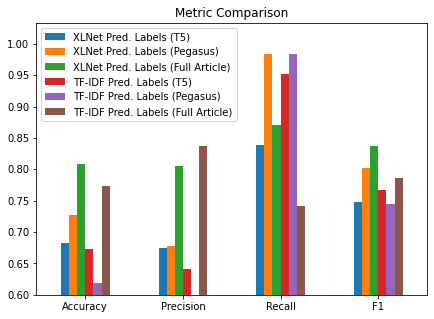

In [135]:
ax = df.plot.bar(rot=0)
ax.set_ylim(ymin=0.6)
ax.figure.set_size_inches(7, 5)
plt.title('Metric Comparison')
# plt.show()
plt.savefig('predlabelmodelmetriccomparison.jpg')

Text(0.5, 1.0, 'Metric Comparison')

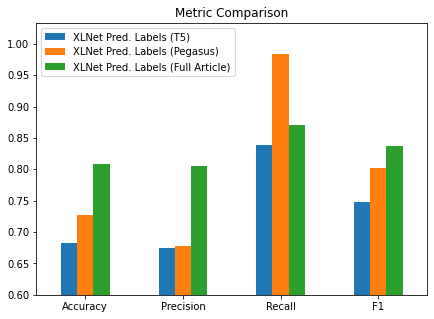

In [136]:
ax = df[["XLNet Pred. Labels (T5)", "XLNet Pred. Labels (Pegasus)", "XLNet Pred. Labels (Full Article)"]].plot.bar(rot=0)
ax.set_ylim(ymin=0.6)
ax.figure.set_size_inches(7, 5)
plt.title('Metric Comparison')

Text(0.5, 1.0, 'Metric Comparison')

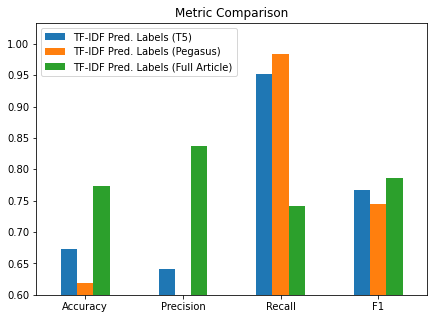

In [137]:
ax = df[["TF-IDF Pred. Labels (T5)", "TF-IDF Pred. Labels (Pegasus)", "TF-IDF Pred. Labels (Full Article)"]].plot.bar(rot=0)
ax.set_ylim(ymin=0.6)
ax.figure.set_size_inches(7, 5)
plt.title('Metric Comparison')

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.bar()


(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
bertmodeldata = pd.read_table("bertmodeldata.csv", sep='\t', index_col=0)
robertamodeldata = pd.read_table("robertamodeldata.csv", sep='\t', index_col=0)
# frozenrobertamodeldata = pd.read_table("frozenrobertamodeldata.csv", sep='\t', index_col=0)
xlnetmodeldata = pd.read_table("xlnetmodeldata.csv", sep='\t', index_col=0)
# frozenxlnetmodeldata = pd.read_table("frozenxlnetmodeldata.csv", sep='\t', index_col=0)
albertmodeldata = pd.read_table("albertmodeldata.csv", sep='\t', index_col=0)


In [ ]:
bert_val_acc = bertmodeldata['ValAccuracy']
roberta_val_acc = robertamodeldata['ValAccuracy']
xlnet_val_acc = xlnetmodeldata['ValAccuracy']
albert_val_acc = albertmodeldata['ValAccuracy']

bert_val_loss = bertmodeldata['Val_loss']
roberta_val_loss = robertamodeldata['Val_loss']
# frozenroberta_val_loss = frozenrobertamodeldata['Val_loss']
xlnet_val_loss = xlnetmodeldata['Val_loss']
# frozenxlnet_val_loss = frozenxlnetmodeldata['Val_loss']
albert_val_loss = albertmodeldata['Val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bert_val_acc, label='BERT')
plt.plot(epochs_range, roberta_val_acc, label='RoBERTa')
# plt.plot(epochs_range, frozenroberta_val_acc, label='RoBERTa (6 layers trained)')
plt.plot(epochs_range, xlnet_val_acc, label='XLNet')
plt.plot(epochs_range, albert_val_loss, label='ALBERT')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bert_val_loss, label='BERT')
plt.plot(epochs_range, roberta_val_loss, label='RoBERTa')
# plt.plot(epochs_range, frozenroberta_val_loss, label='RoBERTa (6 layers trained)')
plt.plot(epochs_range, xlnet_val_loss, label='XLNet')
plt.plot(epochs_range, albert_val_loss, label='ALBERT')
plt.legend(loc='upper right')
plt.title('Validation Loss')
# plt.show()
plt.savefig('modeltrainingcomparison.jpg')

In [ ]:
# plot accuracy

In [ ]:
def findcommonlabel(predictionlist):
    labellist = []
    for i in range(len(predictionlist[1])):
        allin = True
        labeli = predictionlist[0][i]
        for ii in range(len(predictionlist)):
            if predictionlist[ii][i] !=labeli:
                allin = False
        if allin == True:
            labellist.append(i)
    return labellist

In [ ]:
commonpred = findcommonlabel(predictions)
len(commonpred)

In [ ]:
test_section.reset_index(inplace=True)
test_section.head()

In [ ]:
commonpreddata = test_section.iloc[commonpred]
commonpreddata.shape

In [ ]:
commonpreddata["label"].value_counts().plot.bar()

In [ ]:
plt.hist(commonpreddata.length)


In [ ]:
mixedpreddata = test_section.drop(commonpred, errors='ignore')
mixedpreddata.shape

In [ ]:
mixedpreddata["label"].value_counts().plot.bar()

In [ ]:
plt.hist(mixedpreddata.length)


In [ ]:
for i in range(len(names)):
    test_section[names[i]] = predictions[i]
test_section['encodedlabel'] = test_labels
test_section.head()

In [ ]:
def calculateproportions(df, colname):
    biases = df[df[colname] == 0]
    neutrals = df[df[colname] == 1]
    length = df.shape[0]
    return biases.shape[0]/length, neutrals.shape[0]/length

In [ ]:
realbiasproportions, realneutralproportions = calculateproportions(test_section, "encodedlabel")
bertbiasproportions, bertneutralproportions = calculateproportions(test_section, "BERT")
robertabiasproportions, robertaneutralproportions = calculateproportions(test_section, "RoBERTa")
xlnetbiasproportions, xlnetneutralproportions = calculateproportions(test_section, "XLNet")
albertbiasproportions, albertneutralproportions = calculateproportions(test_section, "ALBERT")

biasproplist = [realbiasproportions,
               bertbiasproportions,
               robertabiasproportions,
                xlnetbiasproportions,
                albertbiasproportions]
neutralproplist = [realneutralproportions,
               bertneutralproportions,
               robertaneutralproportions,
                xlnetneutralproportions,
                albertneutralproportions]
                
totalnames = ["Data", "BERT","RoBERTa", "XLNet", "ALBERT"]
plt.bar(range(0, len(biasproplist)), biasproplist, width = 0.25, tick_label = totalnames)
plt.ylim(ymin=0.3)
plt.title('Proportions of Biased Labels')



In [ ]:
plt.bar(range(0, len(neutralproplist)), neutralproplist, width = 0.25, tick_label = totalnames)
plt.ylim(ymin=0.5)
plt.title('Proportions of Neutral Labels')



In [ ]:
test_section[:10]

In [ ]:
realneutraldata = test_section[(test_section["encodedlabel"] ==1)
            & (test_section["BERT"]== 0)
             & (test_section["RoBERTa"]== 0)
             & (test_section["XLNet"]== 0)
             & (test_section["ALBERT"]== 0)]
realneutraldata

In [ ]:
test_section.iloc[9].url

In [ ]:
test_section.iloc[9].article

In [ ]:
xlnetbiasvsneutral = test_section[(test_section["encodedlabel"] ==1)
             & (test_section["XLNet"]== 0)]
xlnetbiasvsneutral

In [ ]:
realbiasdata = test_section[(test_section["encodedlabel"] ==0)
            & (test_section["BERT"]== 1)
             & (test_section["RoBERTa"]== 1)
             & (test_section["XLNet"]== 1)]
realbiasdata

In [ ]:
test_section[(test_section["encodedlabel"] ==0)
            & (test_section["XLNet"]== 1)]